# Question 3

A model for the flow rate of water (in $m^3$/year) through a borehole is given by the following equation:


\begin{equation*}
y(\boldsymbol{\theta}) =
\frac{2\pi T_u \left(H_u - H_l\right)}
{\ln\left(\frac{r}{r_w}\right)\left(1 + \frac{2LT_u}{\ln\left(\frac{r}{r_w}\right)r_w^2K_w} + \frac{T_u}{T_l}\right)}
\end{equation*}

There are 8 parameters which are all independent except $T_u$ and $T_l$ which are correlated with a coefficient of correlation of 0.4, and $H_u$, which is conditional on $H_l$. The parameter vector $\boldsymbol{\theta}$ is defined as $\left[r_w, r, T_u, H_u, T_l, H_l, L, K_w \right]$. 

The probability that the flow rate will exceed a threshold $\beta$ is given by:


\begin{equation*}
P\left(y \ge \beta \right) = \int I\left[y(\boldsymbol{\theta}) \ge \beta \right] p(\boldsymbol{\theta})d\boldsymbol{\theta}
\end{equation*}

This will be denoted as: 

\begin{equation*}
\alpha = \int f(\boldsymbol{\theta}) p(\boldsymbol{\theta})d\boldsymbol{\theta}
\end{equation*}

for convenience.

### (a) A computer program in Python using a direct Monte Carlo method with 1000 samples to calculate $P\left(y \ge \beta_1 \right)$ for $\beta_1$ = 150 $m^3$/year 

#### Importing modules

In [1]:
from scipy.stats import lognorm, uniform, gaussian_kde, beta, truncnorm, triang
from scipy.stats import norm as gaussian
from scipy.stats import multivariate_normal as mvn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import time

#### Building the distributions for the model parameters

In [2]:
rw = uniform(loc=0.1, scale=(0.2-0.1))
r = lognorm(s=2, scale=np.exp(5))
tu = gaussian(loc=89000, scale=8900)
hl = uniform(loc=700, scale=(820-700))
tl = gaussian(loc=89, scale=8.9)
# hu = uniform(loc=100, scale=(200-100))
hu = triang(c=0.5, loc=800, scale=220)
l = uniform(loc=1120, scale=(1680-1120))
kw = uniform(loc=9500, scale=(13000-9500))

dists = [rw, r, tu, hl, tl, hu, l, kw]

m1 = 89000
m2 = 89
s1 = 8900
s2 = 8.9
rho = 0.4

cov = np.array([[s1**2, rho*s1*s2], [rho*s1*s2, s2**2]])
mean = np.array([m1, m2])

tu_tl = mvn(mean=mean, cov=cov)

#### Plotting the pdfs of the parameters

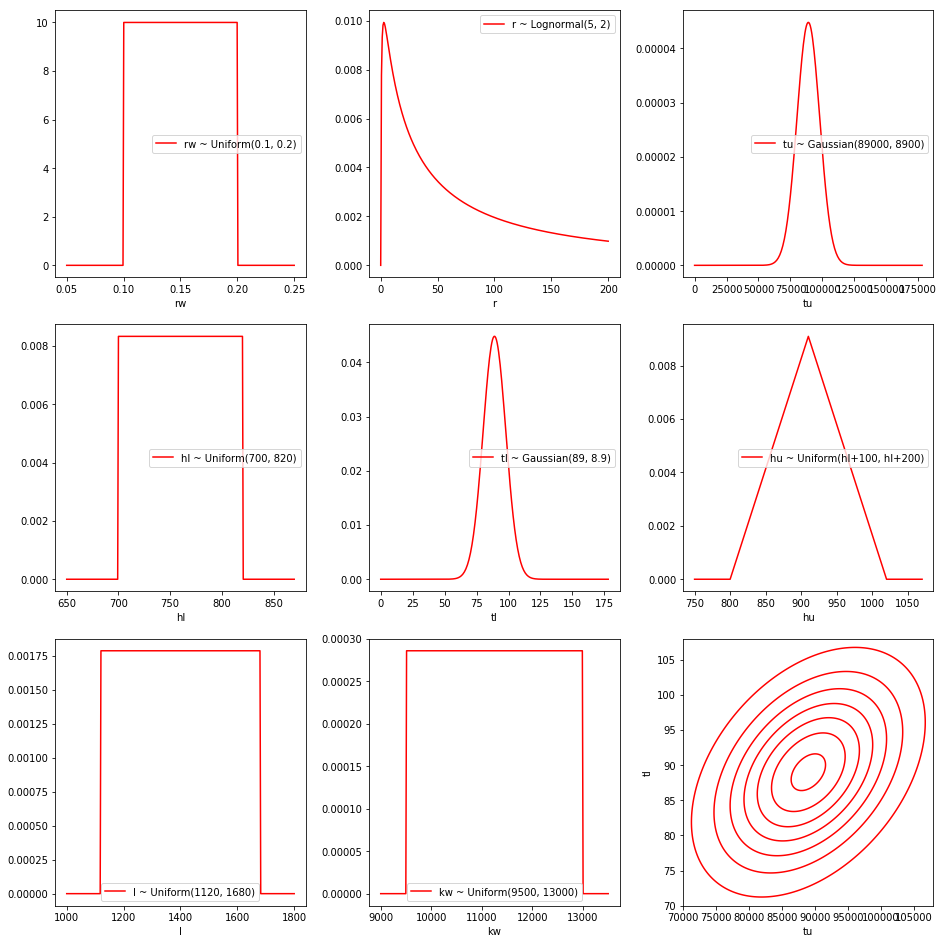

In [3]:
# Variables used for defining the plots
par_names = ["rw", "r", "tu", "hl", "tl", "hu", "l", "kw"]
labels = ["rw ~ Uniform(0.1, 0.2)", "r ~ Lognormal(5, 2)", 
          "tu ~ Gaussian(89000, 8900)", "hl ~ Uniform(700, 820)", 
          "tl ~ Gaussian(89, 8.9)", "hu ~ Uniform(hl+100, hl+200)", 
          "l ~ Uniform(1120, 1680)", "kw ~ Uniform(9500, 13000)"]
lower = [0.05, 0, 0, 650, 0, 650, 1000, 9000]
upper = [0.25, 200, 2*89000, 870, 2*89, 1120, 1800, 13500]
nrow = 3
ncol = 3
figsize = (4*ncol+1, 4*nrow+1)

# Plots
f, axs = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    if i < len(dists):
        if i == 5:
            ax.plot([750, 800, 910, 1020, 1070], [0, 0, 1/(0.5*220), 0, 0], 'r-', label=labels[i])
        else:
            x = np.linspace(lower[i], upper[i], 300)
            ax.plot(x, dists[i].pdf(x), 'r-', label=labels[i])
        ax.set_xlabel(par_names[i])
        ax.legend()
    if i == len(dists):
        xv = np.linspace(70000, 108000, 200)
        yv = np.linspace(70, 108, 300)
        x, y = np.meshgrid(xv, yv)
        pos = np.stack((x, y), axis=-1)
        ax.contour(x, y, tu_tl.pdf(pos), colors='r')
        ax.set_xlabel("tu")
        ax.set_ylabel("tl")
plt.show()

#### Defining the model

In [4]:
def flow_rate_model(rw, r, tu, hl, tl, hu, l, kw):
    numerator = 2*np.pi*tu*(hu-hl)
    denominator = np.log(r/rw)*(1 + 2*l*tu/(np.log(r/rw)*rw**2*kw) + tu/tl)
    y = numerator/denominator
    return y

#### Define the probability of exceedence

In [5]:
def prob_exceedence(samples, threshold):
    return np.sum(samples >= threshold)/np.shape(samples)[0]

#### Drawing samples from the distribution of the parameters

In [6]:
dists = [rw, r, tu, hl, tl, hu, l, kw]
nsamples = 1000
samples = [dist.rvs(nsamples) for dist in dists]
mvn_samples = tu_tl.rvs(nsamples)

samples[2] = mvn_samples[:, 0]
samples[4] = mvn_samples[:, 1]

#### Plotting the samples

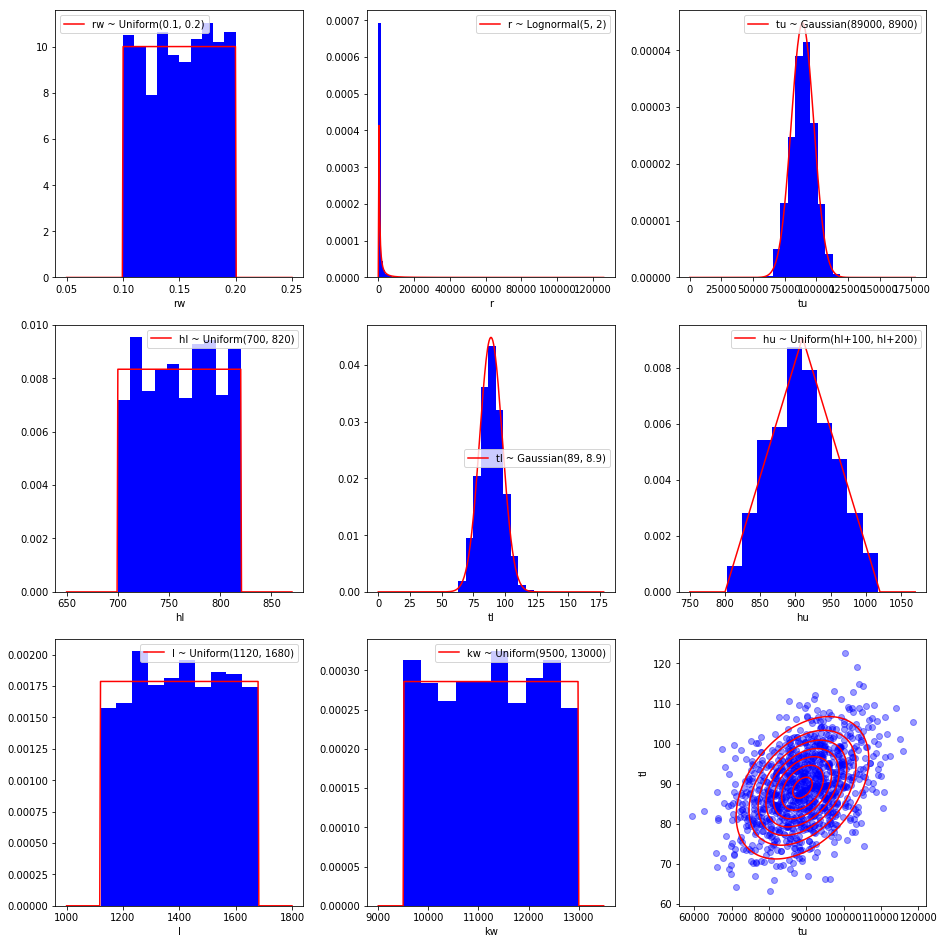

In [7]:
f, axs = plt.subplots(nrow, ncol, figsize=(4*ncol+1, 4*nrow+1), constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    if i < len(dists):
        if i == 1:
            x = np.linspace(lower[i], max(samples[i]), 300)
            ax.hist(samples[i], density=True, bins=100, color='b')
        else:
            x = np.linspace(lower[i], upper[i], 300)
            ax.hist(samples[i], density=True, color='b')
        if i == 5:
            ax.plot([750, 800, 910, 1020, 1070], [0, 0, 1/(0.5*220), 0, 0], 'r-', label=labels[i])
        else:
            ax.plot(x, dists[i].pdf(x), 'r-', label=labels[i])
        ax.set_xlabel(par_names[i])
        ax.legend()
    if i == len(dists):
        xv = np.linspace(70000, 108000, 200)
        yv = np.linspace(70, 108, 300)
        x, y = np.meshgrid(xv, yv)
        pos = np.stack((x, y), axis=-1)
        ax.contour(x, y, tu_tl.pdf(pos), colors='red')
        ax.scatter(samples[2], samples[4], c='b', alpha=0.4)
        ax.set_xlabel("tu")
        ax.set_ylabel("tl")
plt.show()

#### Evaluating the model

In [8]:
y = flow_rate_model(samples[0], samples[1], samples[2], samples[3], 
                    samples[4], samples[5], samples[6], samples[7])

beta_1 = 150;
beta_2 = 250;
beta_3 = 400;
thresholds = [50, 100, beta_1, beta_2];
for t in thresholds:
    print("Probability of the flow rate exceeding a threshold of " + str(t) + " m^3/year is computed to be " 
          + str(prob_exceedence(y, t)) + " using " + str(np.shape(samples)[1]) + " samples.")

Probability of the flow rate exceeding a threshold of 50 m^3/year is computed to be 0.755 using 1000 samples.
Probability of the flow rate exceeding a threshold of 100 m^3/year is computed to be 0.338 using 1000 samples.
Probability of the flow rate exceeding a threshold of 150 m^3/year is computed to be 0.13 using 1000 samples.
Probability of the flow rate exceeding a threshold of 250 m^3/year is computed to be 0.008 using 1000 samples.


#### Coefficient of variation of the estimator

Here, the unknown quantity which is being estimated is the probability of the flow rate exceeding a threshold i.e., $P\left(y \ge \beta \right)$. Denoting this as $\alpha$, we estimate $\alpha$ using an estimator $\hat{\alpha}$, which is a random variable whose value depends on the samples of the flow rate used in the computation. 

\begin{equation*}
\hat{\alpha} = \frac{1}{N}\sum_{i=1}^N y_i
\end{equation*}

The variance of this estimator is given by:
\begin{equation*}
Var\left(\hat{\alpha}\right) = Var\left(\frac{1}{N}\sum_{i=1}^N y_i\right) = \frac{1}{N^2} Var\left(\sum_{i=1}^N y_i\right)
\end{equation*}

Since the samples $y_i$ are independent and identically distributed, this becomes:
\begin{equation*}
\frac{1}{N^2} Var\left(\sum_{i=1}^N y_i\right) = \frac{1}{N^2} \sum_{i=1}^N Var\left(y_i\right) = \frac{1}{N^2} * N * Var\left(y_i\right) = \frac{Var\left(y_i\right)}{N}
\end{equation*}

Since $Var\left(y_i\right)$ is unknown, this is estimated by the sample variance $s^2$. Hence:
\begin{equation*}
Var\left(\hat{\alpha}\right) = \frac{s^2}{N} = \frac{s^2}{1000}
\end{equation*}
since we use 1000 samples in the estimator.

In [9]:
sample_variance = np.var(y, ddof=1)
print("The estimated variance of the Monte Carlo estimator is: ", sample_variance/nsamples, " (m^3/year)^2.")

The estimated variance of the Monte Carlo estimator is:  2.641373769373712  (m^3/year)^2.


### (b) Approximating the probability density of the flow rate using the same sample set

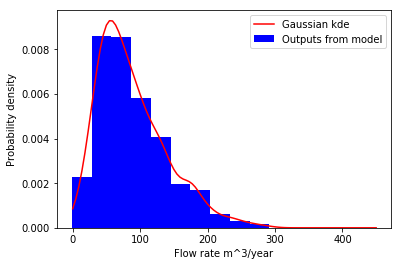

In [10]:
plt.hist(y, density=True, color='b', label='Outputs from model')
x = np.linspace(0, 450, 100)
kde = gaussian_kde(y)
plt.plot(x, kde(x), 'r-', label='Gaussian kde')
plt.xlabel("Flow rate m^3/year")
plt.ylabel("Probability density")
plt.legend()
plt.show()

### (c) Importance sampling

#### Visualizing the dataset

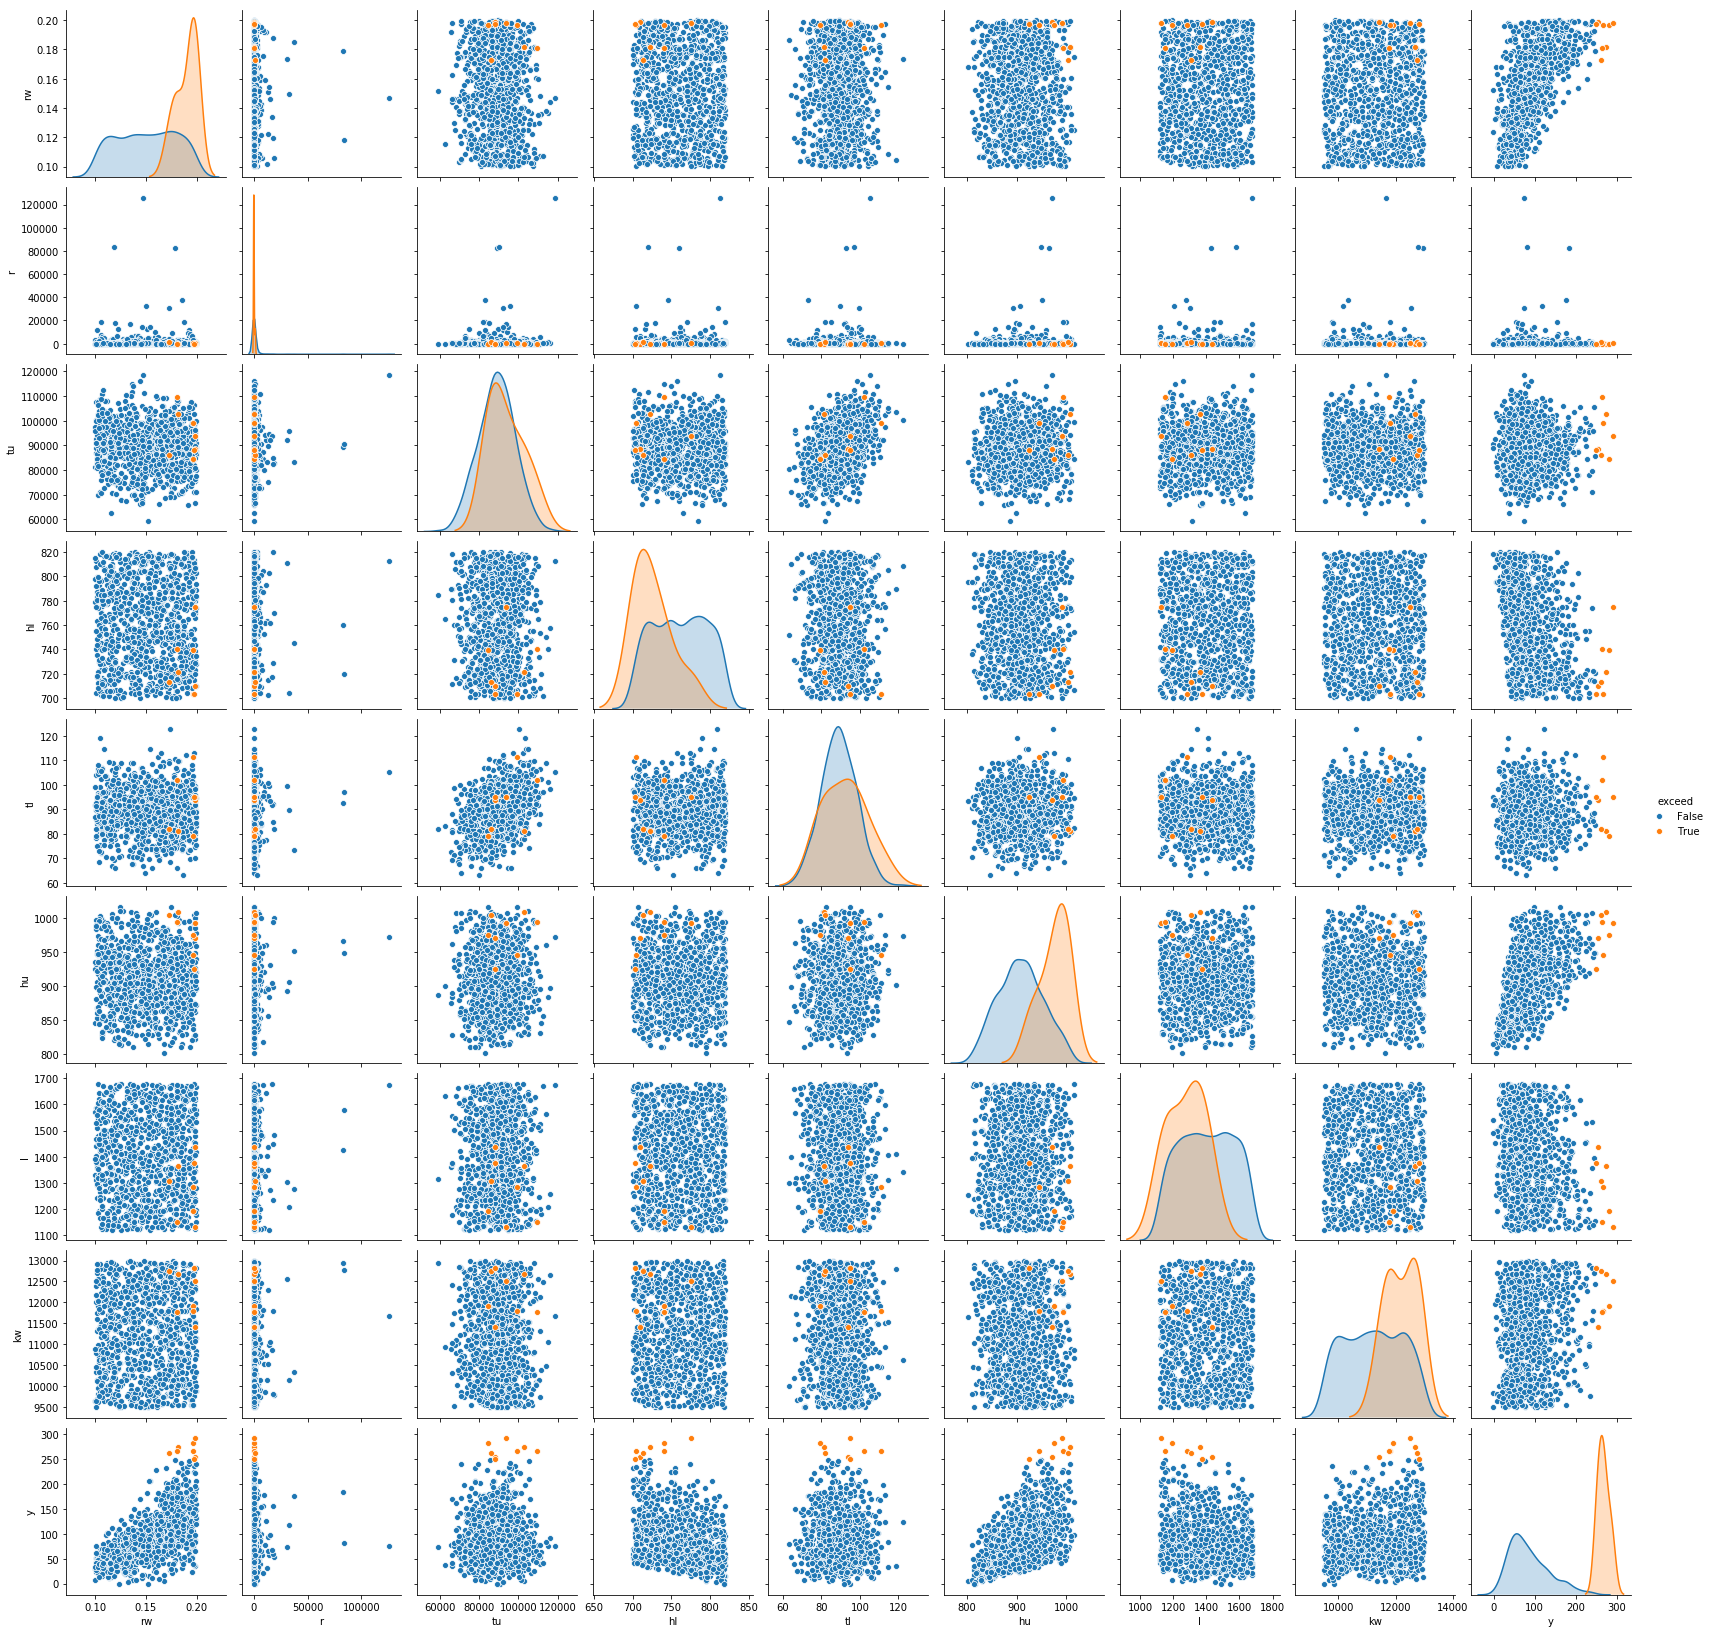

In [11]:
s = np.array(samples).T
df = pd.DataFrame(s, columns=["rw", "r", "tu", "hl", "tl", "hu", "l", "kw"])
df["y"] = y
thresh = 250
df["exceed"] = y >= thresh
df_exceed = df[df["exceed"]]
g = sns.pairplot(df, corner=False, diag_kind="kde", hue="exceed")

#### Choosing importance sampling densities

In [12]:
imp_rw = beta(a=8, b=1.2, loc=0.1, scale=0.1)
imp_r = truncnorm(a=-100/600, b=np.inf, loc=100, scale=600)
imp_tu = gaussian(loc=89000, scale=15000)
imp_hl = beta(a=1.5, b=6, loc=700, scale=120)
imp_tl = gaussian(loc=89, scale=20)
imp_hu = beta(a=4, b=2, loc=800, scale=220)
imp_l = beta(a=1.5, b=4, loc=1120, scale=560)
imp_kw = beta(a=4, b=1.5, loc=9500, scale=3500)

dists_imp = [imp_rw, imp_r, imp_tu, imp_hl, imp_tl, imp_hu, imp_l, imp_kw]

#### Plotting the chosen importance sampling densities

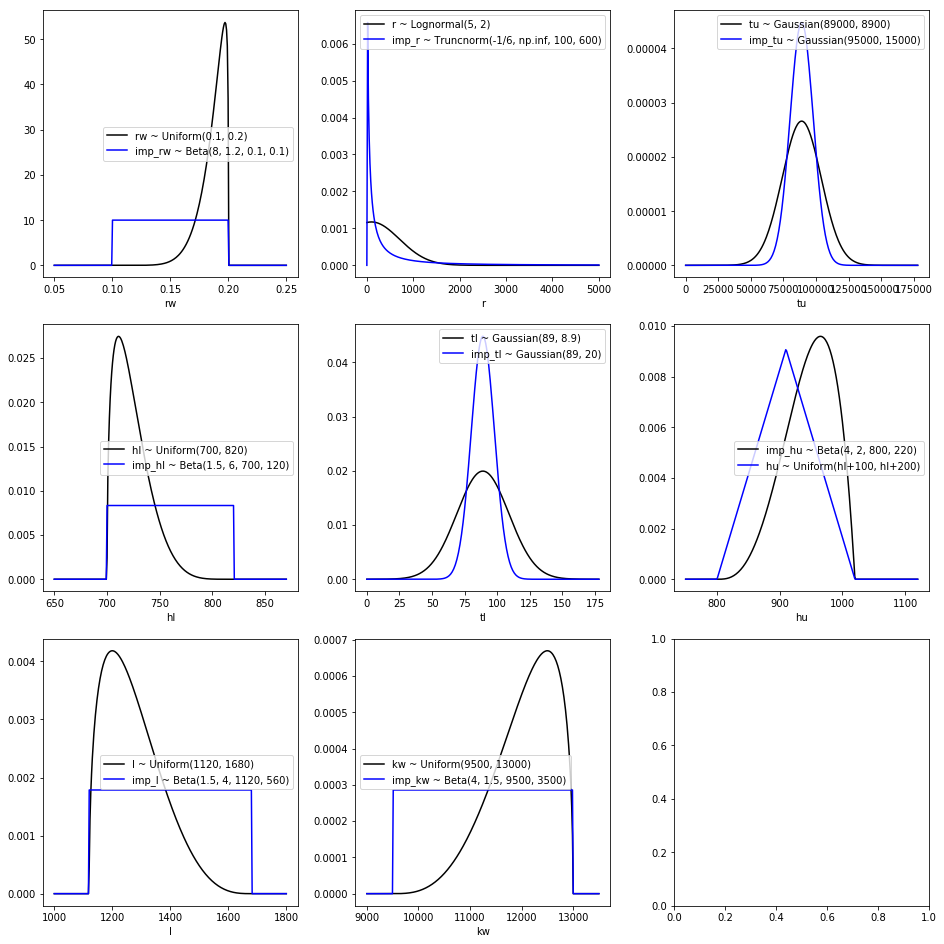

In [13]:
# Plotting
lower = [0.05, 0, 0, 650, 0, 750, 1000, 9000]
upper = [0.25, 5000, 2*89000, 870, 2*89, 1120, 1800, 13500]
nrow = 3
ncol = 3
figsize = (4*ncol+1, 4*nrow+1)
imp_labels = ["imp_rw ~ Beta(8, 1.2, 0.1, 0.1)", "imp_r ~ Truncnorm(-1/6, np.inf, 100, 600)", 
          "imp_tu ~ Gaussian(95000, 15000)", "imp_hl ~ Beta(1.5, 6, 700, 120)", 
          "imp_tl ~ Gaussian(89, 20)", "imp_hu ~ Beta(4, 2, 800, 220)", 
          "imp_l ~ Beta(1.5, 4, 1120, 560)", "imp_kw ~ Beta(4, 1.5, 9500, 3500)"]

# Plots
f, axs = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    if i < len(dists_imp):
        if i == 5:
            x = np.linspace(lower[i], upper[i], 300)
            ax.plot(x, dists_imp[i].pdf(x), 'k-', label=imp_labels[i])
            ax.plot(x, dists[i].pdf(x), 'b-', label=labels[i])
            y = gaussian_kde(df_exceed.iloc[:, i])
#             ax.plot(x, y(x)*max(dists_imp[i].pdf(x))/max(y(x)), 'r-')
        else:
            x = np.linspace(lower[i], upper[i], 300)
            ax.plot(x, dists_imp[i].pdf(x), 'k-', label=labels[i])
            ax.plot(x, dists[i].pdf(x), 'b-', label=imp_labels[i])
            y = gaussian_kde(df_exceed.iloc[:, i])
#             ax.plot(x, y(x)*max(dists_imp[i].pdf(x))/max(y(x)), 'r-')
        ax.set_xlabel(par_names[i])
        ax.legend()
plt.show()

#### Estimating the probability of exceeding the threshold using importance sampling

Using importance sampling, the probability of exceedence, $\alpha_p = \int f(\boldsymbol{\theta})p(\boldsymbol{\theta})d\boldsymbol{\theta}$ is instead computed as:

\begin{equation*}
\alpha_q = \int \frac{f(\boldsymbol{\theta})p(\boldsymbol{\theta})}{q(\boldsymbol{\theta})}q(\boldsymbol{\theta})d\boldsymbol{\theta}
\end{equation*}

This is estimated as:

\begin{equation*}
\hat{\alpha_q} = \frac{1}{N}\sum_{i=1}^N f(\boldsymbol{\theta}) \frac{p(\boldsymbol{\theta})}{q(\boldsymbol{\theta})}
\end{equation*}

where the samples of $\boldsymbol{\theta}$ are drawn from the importance sampling densities $q(\boldsymbol{\theta})$ instead of from $p(\boldsymbol{\theta})$ as before.

#### Calculations using importance sampling

In [14]:
nsamples = 1000
samples_imp = [dist.rvs(nsamples) for dist in dists_imp]

y_imp = flow_rate_model(samples_imp[0], samples_imp[1], samples_imp[2], samples_imp[3], 
                        samples_imp[4], samples_imp[5], samples_imp[6], samples_imp[7])

p_theta = np.ones((nsamples,))
for i in range(7):
    if i in (0, 1, 3, 5, 6, 7):
        p_theta *= dists[i].pdf(samples_imp[i])
x_pdf = [(samples_imp[2][i], samples_imp[4][i]) for i in range(nsamples)]
p_mvn = tu_tl.pdf(x_pdf)
p_theta = p_theta*np.array(p_mvn)

q_theta = np.ones((nsamples,))
for i in range(7):
    q_theta *= dists_imp[i].pdf(samples_imp[i])

ratios = p_theta/q_theta

#### Defining the probability of exceedence using importance sampling

In [15]:
def prob_exceedence_imp(samples, ratios, threshold):
    exceed = y_imp >= threshold
    pe = np.sum(np.dot(exceed, ratios))/nsamples
    return pe

#### Estimating the probability of exceedence using importance sampling

In [16]:
beta_1 = 150;
beta_2 = 250;
beta_3 = 400;
thresholds = [beta_2, beta_3];
for t in thresholds:
    print("Probability of the flow rate exceeding a threshold of " + str(t) + " m^3/year is computed to be " 
          + str(prob_exceedence_imp(samples, ratios, t)) + " using " + str(np.shape(samples)[1]) + 
          " samples and importance sampling.")

Probability of the flow rate exceeding a threshold of 250 m^3/year is computed to be 0.009486754853192739 using 1000 samples and importance sampling.
Probability of the flow rate exceeding a threshold of 400 m^3/year is computed to be 0.0 using 1000 samples and importance sampling.


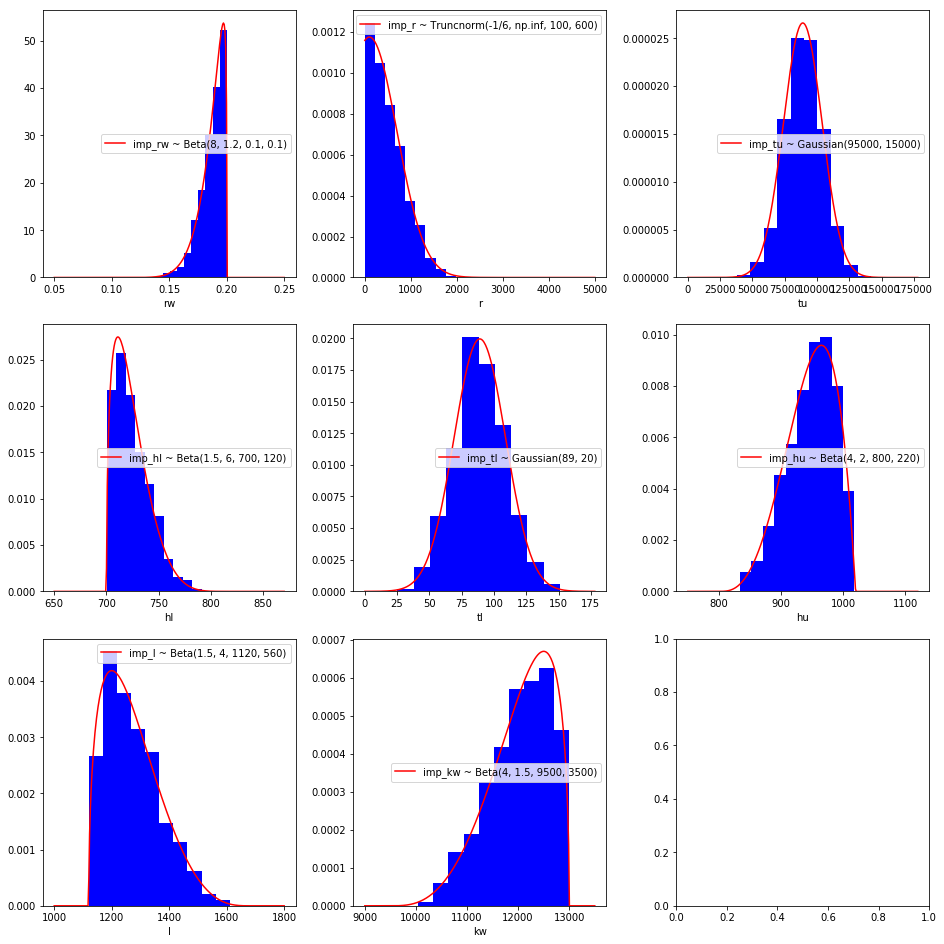

In [17]:
f, axs = plt.subplots(nrow, ncol, figsize=(4*ncol+1, 4*nrow+1), constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    if i < len(dists):
        x = np.linspace(lower[i], upper[i], 300)
        ax.hist(samples_imp[i], density=True, color='b')
        ax.plot(x, dists_imp[i].pdf(x), 'r-', label=imp_labels[i])
        ax.set_xlabel(par_names[i])
        ax.legend()
plt.show()

### (f) Drawing samples from the posterior $p(\boldsymbol{\theta}_m, \sigma_e | \boldsymbol{D})$

#### Reading the input and output data

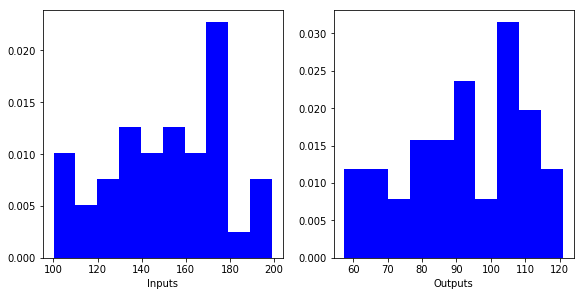

In [18]:
inputs = np.loadtxt("input.txt")
outputs = np.loadtxt("output.txt")

fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
axs[0].hist(inputs, density=True, color='b')
axs[0].set_xlabel("Inputs")
axs[1].hist(outputs, density=True, color='b')
axs[1].set_xlabel("Outputs")

plt.show()

The posterior probability $p(\boldsymbol{\theta}_m, \sigma_e | \boldsymbol{D})$ is given by Bayes' rule as: 
\begin{equation*}
p(\boldsymbol{\theta}_m, \sigma_e | \boldsymbol{D}) = \frac{p(\boldsymbol{D} | \boldsymbol{\theta}_m, \sigma_e) p(\boldsymbol{\theta}_m, \sigma_e)}{p(\boldsymbol{D})} 
\end{equation*}
where, $p(\boldsymbol{D}) = \int {p(\boldsymbol{D} | \boldsymbol{\theta}_m, \sigma_e) p(\boldsymbol{\theta}_m, \sigma_e)}$.

Assuming that $\sigma_e$ is independent of $\boldsymbol{\theta}_m$, $p(\boldsymbol{\theta}_m, \sigma_e | \boldsymbol{D}) = p(\boldsymbol{\theta}_m | \boldsymbol{D}) * p(\sigma_e | \boldsymbol{D})$. An augmented parameter vector $\hat{\boldsymbol{\theta}_m}$ can be built whose components are $\left[r_w, r, T_u, T_l, L, K_w, \sigma_e \right]$. Then, Bayes' rule can be written as:

\begin{equation*}
p(\hat{\boldsymbol{\theta}_m} | \boldsymbol{D}) = \frac{p(\boldsymbol{D} | \hat{\boldsymbol{\theta}_m}) p(\boldsymbol{\hat{\theta}_m})}{p(\boldsymbol{D})} 
\end{equation*}

The likelihood $p(\boldsymbol{D} | \hat{\boldsymbol{\theta}_m})$ is of the same form as given in the question, with the only difference being that it is additionally conditioned on sample values of the standard deviation. 

The prior $p(\hat{\boldsymbol{\theta}_m})$ is given by the product of the priors on $[r_w, r, L, K_w, \sigma_e]$ multiplied by the multivariate normal distribution of $T_u$ and $T_l$. The priors on $[r_w, r, L, K_w]$ are assumed to be as defined in the question and the prior on $\sigma_e$ is uniform over $[0, 10]$.

####  Sampling from the priors

In [19]:
# sigma_e = uniform(loc=0, scale=10)
# priors = [rw, r, tu_tl, l, kw, sigma_e]
# nsamples_prior = 20
# samples_temp = [dist.rvs(nsamples_prior) for dist in priors]
# mvn_prior_samples = tu_tl.rvs(nsamples_prior)
# samples_prior = [samples_temp[0], samples_temp[1], mvn_prior_samples[:, 0], mvn_prior_samples[:, 1],
#                  samples_temp[3], samples_temp[4], samples_temp[5]]

#### Defining the likelihood function and priors

In [20]:
def sums_of_squared_differences(differentials, param_vals, y_measurements):
    ssqds = np.zeros((np.shape(param_vals)[0],))
    for i in range(np.shape(param_vals)[0]):
        s = param_vals[i, :]
        y_predictions = []
        for j in range(len(differentials)):
            d = differentials[j]
            y_predictions.append(flow_rate_model(s[0], s[1], s[2], 0, s[3], d, s[4], s[5]))
        ssqds[i] = np.sum((y_measurements - np.array(y_predictions))**2)
    return ssqds
            
        
def likelihood(samples, inputs=inputs, outputs=outputs):
    sigma_samples = samples[:,-1]
    param_vals = samples[:, :-1]
    ssqds = sums_of_squared_differences(inputs, param_vals, outputs)
    likelihoods = np.zeros((np.shape(samples)[0], ))
    m = len(inputs)
    for i, s in enumerate(sigma_samples):
        likelihoods[i] = 1/(2*np.pi*s**2)**(m/2)*np.exp(-1/(2*s**2)*ssqds[i])
    return likelihoods

def priors_func(samples):
    sigma_e = uniform(loc=0, scale=10)
    prior = (rw.pdf(samples[:, 0]) * r.pdf(samples[:, 1]) * l.pdf(samples[:, 4]) * kw.pdf(samples[:, 5]) *
             sigma_e.pdf(samples[:, 6]) * tu_tl.pdf(np.hstack((samples[:, 2], samples[:, 3]))))
    return prior
    

In [21]:
# gibbs_samples = np.array([0.15, 10, 89000, 89, 1400, 11000, 5]).reshape(1, 7) # Initiation with arbitrary values
# nsamples_gibbs = 1000
# nburn_in = 1000
# thinning = 2
# nsteps = nburn_in + thinning*nsamples_gibbs
# # for i in range(nsteps):

#### Using Metropolis algorithm to sample from the posterior

In [22]:
t = time.time()
# current_state = np.array([0.15, 10, 89000, 89, 1400, 11000, 5]).reshape(1, 7)
current_state = np.array([0.15, 20, 89000, 89, 1400, 11000, 5]).reshape(1, 7)
nsamples_posterior = 1000
nburn_in = 1000
thinning = 1
nsteps = nburn_in + thinning*nsamples_posterior
# proposal_scales = [0.02, 30, 2000, 10, 50, 35, 1] # 0.7%
# proposal_scales = [0.01, 5, 200, 4, 10, 35, 1] # 1.8%
proposal_scales = [0.01, 10, 200, 2, 10, 35, 1] # 2.5%

posterior_samples = current_state
i = 0
counter = 0
while i < nsteps:
    counter += 1
    if counter%5000 == 0:
        print("Counter: ", counter)
    proposed_step = np.zeros((1, 7))
    for j in range(7):
        proposed_step[0, j] = gaussian(loc=0, scale=proposal_scales[j]).rvs()
    proposed_state = current_state + proposed_step
    while any(proposed_state[0, :] < 0):
        proposed_step = np.zeros((1, 7))
        for j in range(7):
            proposed_step[0, j] = gaussian(loc=0, scale=proposal_scales[j]).rvs()
        proposed_state = current_state + proposed_step
    
    metropolis_ratio = (likelihood(proposed_state)*priors_func(proposed_state)
                        /(likelihood(current_state)*priors_func(current_state)))
    if metropolis_ratio >= 1:
        current_state = proposed_state
        i += 1
        posterior_samples = np.vstack((posterior_samples, current_state))
    elif np.random.random() < metropolis_ratio:
        current_state = proposed_state
        i += 1
        posterior_samples = np.vstack((posterior_samples, current_state))

print("i: ", i)
print("Counter: ", counter)
print("Efficiency: ", i/counter*100, "%")
posterior_samples = posterior_samples[nburn_in+1:, :]
indicator = range(0, thinning*nsamples_posterior, thinning)
posterior_samples = posterior_samples[indicator, :]
# print(posterior_samples)

print("Done!")
print("Time elapsed: %0.4f seconds." % float(time.time() - t))

Counter:  5000
Counter:  10000
Counter:  15000
Counter:  20000
Counter:  25000
Counter:  30000
Counter:  35000
Counter:  40000
Counter:  45000
Counter:  50000
Counter:  55000
Counter:  60000
Counter:  65000
Counter:  70000
Counter:  75000
Counter:  80000
Counter:  85000
Counter:  90000
Counter:  95000
Counter:  100000
Counter:  105000
i:  2000
Counter:  109939
Efficiency:  1.8191906420833373 %
[[1.42310941e-01 3.86239761e+02 9.64476263e+04 ... 1.26918786e+03
  1.21272906e+04 3.26334807e+00]
 [1.42126776e-01 3.86383232e+02 9.63649163e+04 ... 1.25670755e+03
  1.21817593e+04 1.88565295e+00]
 [1.42441953e-01 3.79951918e+02 9.63705985e+04 ... 1.25247867e+03
  1.21404703e+04 3.23764316e+00]
 ...
 [1.34623709e-01 7.33781529e+01 9.96273127e+04 ... 1.16942961e+03
  1.26510721e+04 2.86984461e+00]
 [1.34289273e-01 7.53332541e+01 9.96211912e+04 ... 1.16883289e+03
  1.26281308e+04 3.04713523e+00]
 [1.35104510e-01 6.69541372e+01 9.88067864e+04 ... 1.17446496e+03
  1.26549984e+04 2.44726214e+00]]
Don

#### Plotting the chains

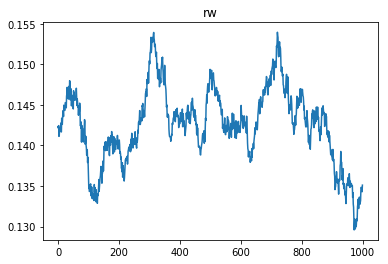

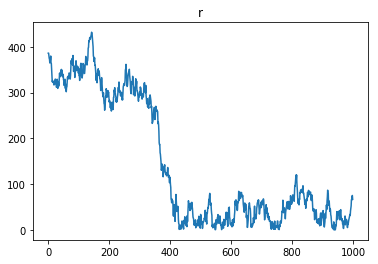

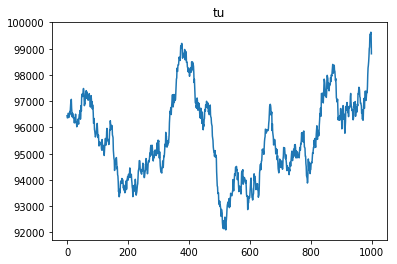

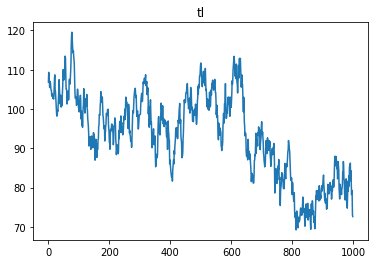

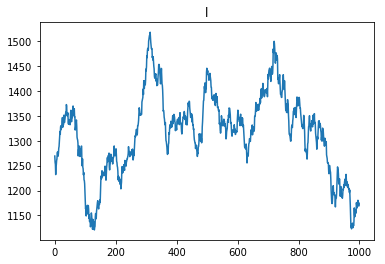

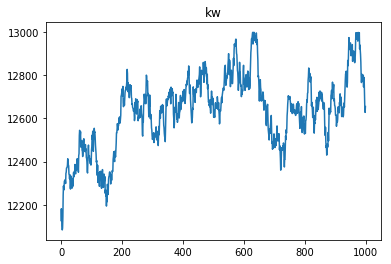

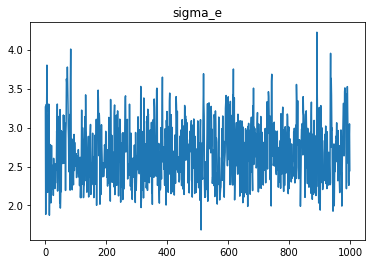

In [23]:
ttls = ["rw", "r", "tu", "tl", "l", "kw", "sigma_e"]
for i in range(7):
    plt.plot(posterior_samples[:, i])
    plt.title(ttls[i])
    plt.show()

#### Plotting the posterior for the six parameters

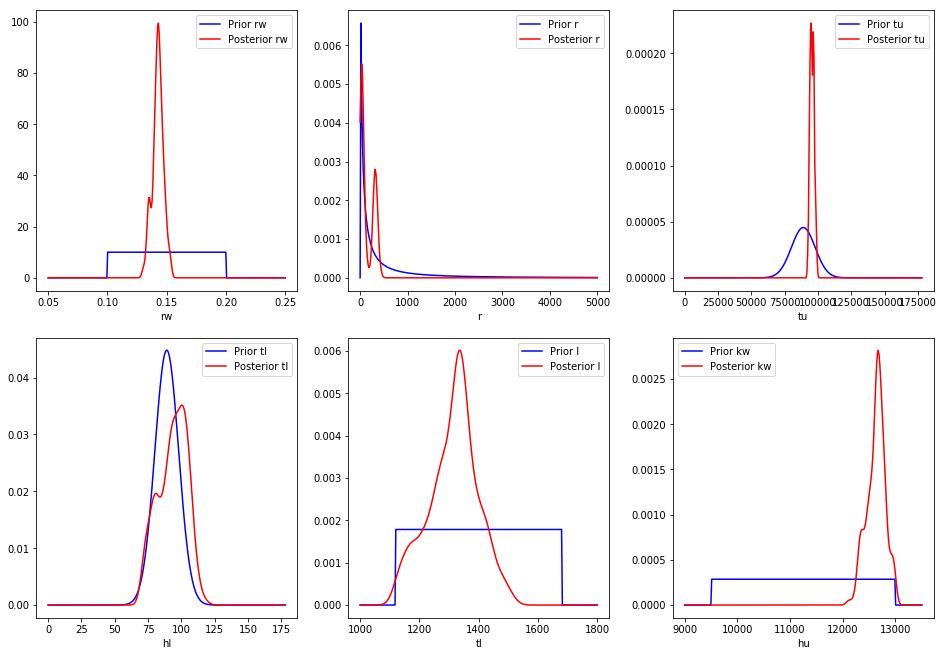

In [27]:
lower = [0.05, 0, 0, 0, 1000, 9000]
upper = [0.25, 5000, 2*89000, 2*89, 1800, 13500]
nrow = 2
ncol = 3
figsize = (4*ncol+1, 4*nrow+1)
prior_dists = [rw, r, tu, tl, l, kw]
# Plots
f, axs = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    if i < len(prior_dists):
        x = np.linspace(min(min(posterior_samples[:, i]), lower[i]), 
                            max(max(posterior_samples[:, i]),upper[i]), 300)
        ax.plot(x, prior_dists[i].pdf(x), 'b-', label="Prior " + ttls[i])
        y = gaussian_kde(posterior_samples[:, i])
        ax.plot(x, y(x), 'r-', label="Posterior " + ttls[i])
        ax.set_xlabel(par_names[i])
        ax.legend()
plt.show()

### (h) Updating the estimate of $\alpha$ with samples from the posterior

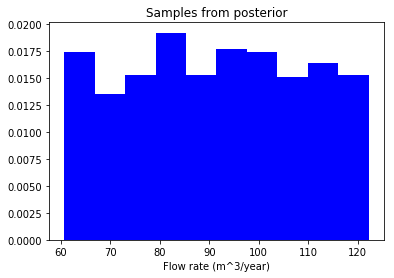

Probability of the flow rate exceeding a threshold of 50 m^3/year is computed to be 1.0 using 1000 samples.
Probability of the flow rate exceeding a threshold of 100 m^3/year is computed to be 0.351 using 1000 samples.
Probability of the flow rate exceeding a threshold of 150 m^3/year is computed to be 0.0 using 1000 samples.
Probability of the flow rate exceeding a threshold of 250 m^3/year is computed to be 0.0 using 1000 samples.


In [37]:
smpls = pd.DataFrame(posterior_samples, columns=ttls)
differential_dist = uniform(loc=100, scale=(200-100))
differential_samples = differential_dist.rvs(size=1000)
                          
y_posterior = flow_rate_model(smpls.iloc[:, 0], smpls.iloc[:, 1], smpls.iloc[:, 2], 
                          np.zeros_like(smpls.iloc[:, 0]), smpls.iloc[:, 3], 
                          differential_samples,
                          smpls.iloc[:, 4], smpls.iloc[:, 5])

plt.hist(y_posterior, density=True, color='b')
plt.xlabel("Flow rate (m^3/year)")
plt.title("Samples from posterior")
plt.show()

beta_1 = 150;
beta_2 = 250;
beta_3 = 400;
thresholds = [50, 100, beta_1, beta_2];
for t in thresholds:
    print("Probability of the flow rate exceeding a threshold of " + str(t) + " m^3/year is computed to be " 
          + str(prob_exceedence(y_posterior, t)) + " using " + str(np.shape(samples)[1]) + " samples.")

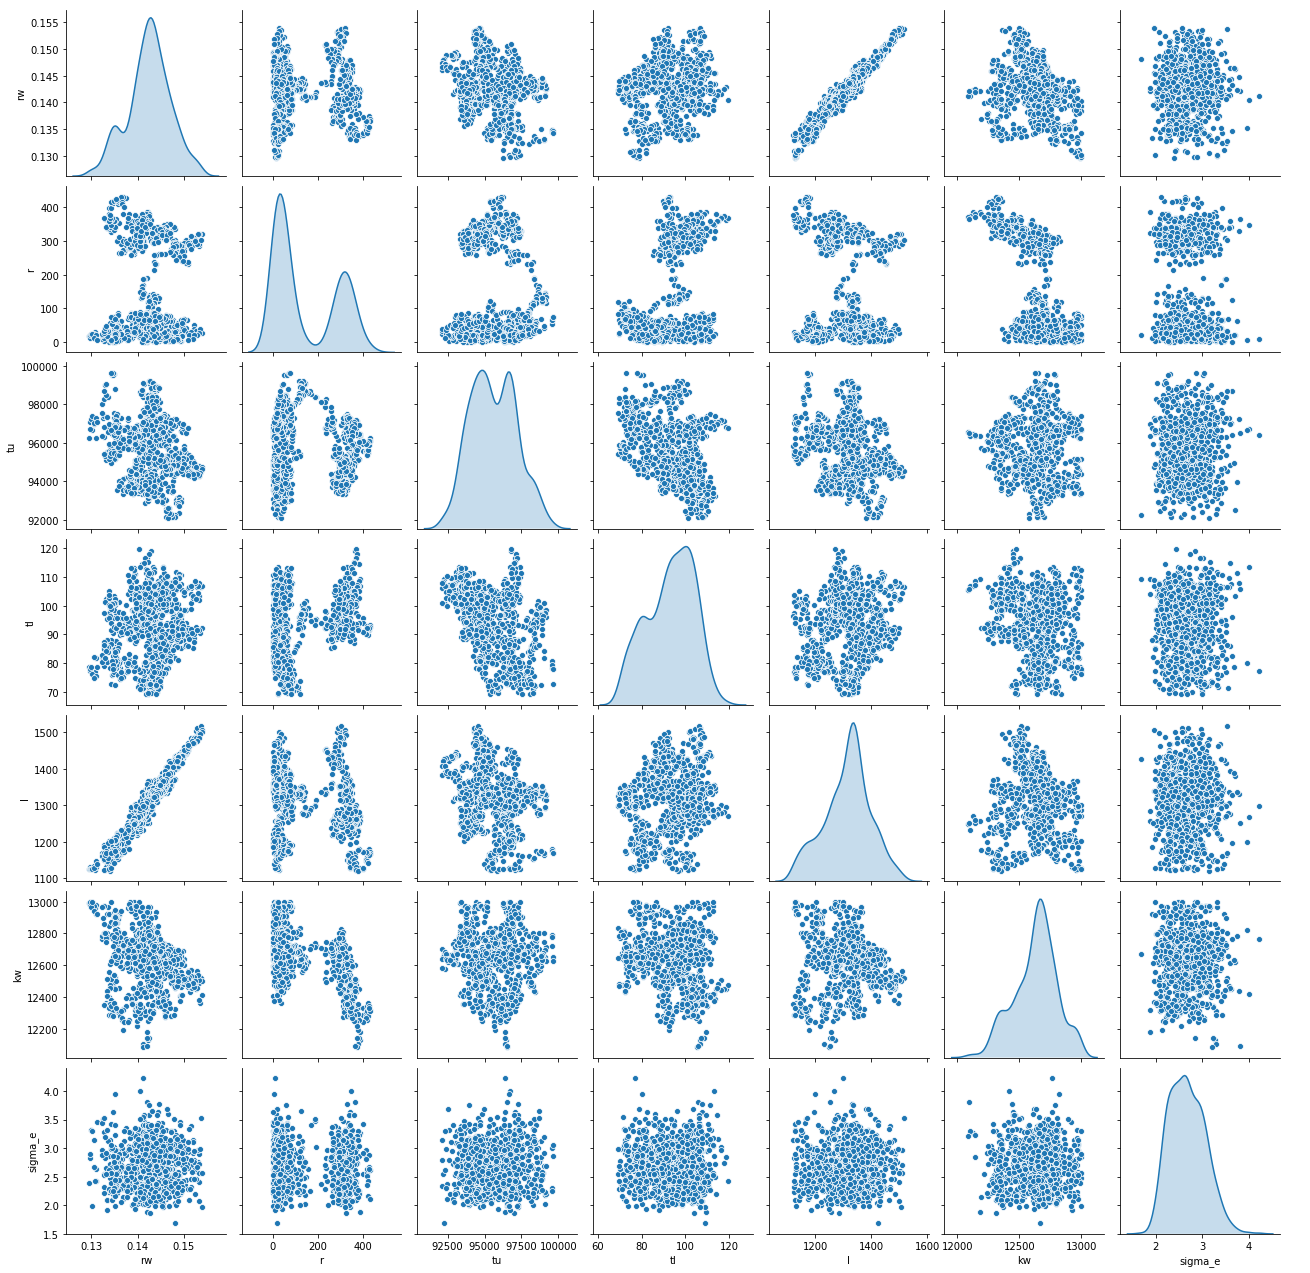

In [26]:
# g = sns.pairplot(smpls, corner=False, diag_kind="kde")